# Introducción

[Clutch](https://clutch.co/) es un sitio B2B (Negocio a negocio, del inglés business-to-business o B2B) de calificaciones y reseñas de empresas tecnológicas. Aquí, éstas son evaluadas en función de una serie de factores cuantitativos y cualitativos entre las que se encuentran reseñas certificadas que realizan sus cliente. Permite constituir una reputación a través de revisiones verificadas de terceros.

No solo es relevante como punto de consulta de información valiosa para la ponderación de proveedores; sino también, como se pretende en el presente, hacer un análisis de la presencia de la competencia en el mercado para establecer puntos de comparación.

# Objetivo

Con este desarrollo se aspira a extraer referencias allí expuesta para constituir una radiografía del mercado. La intensión es simplificar la información en un cuadrante de posicionamiento que permita una rápida comparativa de las empresas que operan en un mismo área (delimitada por rubro y geografía).

La principales técnicas a utilizar son: Web Scraping para recopilar información de forma automática expuesta en Internet, y Text Mining para preprocesar los datos no estructurados obtenidos del portal citado.

# Alcance

El entregable que resulta de este trabajo supone:

- Una pieza de código automatizable que extraiga el texto tal como se expone en el sitio web.
- Preprocesamiento de los registros utilizando técnicas de Text Mining para obtener un set de datos estructurados.
- Reconocer las entidades relevantes de cada lectura para disponer el resultado en forma adecuada para la construcción el resumen pretendido. 

# Consideraciones (a completar)

describir los aspectos a tener en cuenta cuando se hace scraping: CAPTCHA, contenido dinámico, etc.

# Resto de tareas (a completar) 

Cron en hosting
Monitoreo: agente externo para ver si anda -> si anda, me autochequeo
Resolver la caida de internet -> por ejemplo, reintentando
Resolver errores html (40, 50)
Chequear que la estructura cambio o no
Describir cómo construir el dashboard sin construir nada
...

# Futuras lineas de trabajo (a completar)

Extender el origen de información a otros sitios que brinde un servicio de idénticas características.

# Desarrollo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [71]:
import requests
import pandas as pd
import seaborn as sns

from re import sub
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from typing import Iterable, Union

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Categorías

In [3]:
categories = ['app-developers', 'web-developers', 'developers']

## Utilidades

In [4]:
def get_search_page(category: str, page_number: int) -> BeautifulSoup:
  clutch_argentina = requests.get(f'https://clutch.co/ar/{category}?page={page_number}')
  return BeautifulSoup(clutch_argentina.text)

def get_company_profile(profile_link: str) -> BeautifulSoup:
  profile = requests.get(f'https://clutch.co/{profile_link}')
  return BeautifulSoup(profile.text)

def is_last_page(beautiful_soup_page: BeautifulSoup) -> bool:
  return not beautiful_soup_page.select('li.page-item.last > a')

def get_element_text_if_exists(elements: Iterable) -> Union[str, None]:
  if elements is not None and len(elements) > 0:
    return elements[0].text.strip()

def snake_case(value: str) -> str:
  return '_'.join(sub('[^0-9a-zA-Z\s\_]+', '', value).split()).lower()

In [5]:
def create_row(provider_li: BeautifulSoup) -> dict:
    row = {}
    
    company_info = provider_li.select('h3.company_info a')
    row['company_name'] = get_element_text_if_exists(company_info)
    row['rating'] = get_element_text_if_exists(provider_li.select('.rating'))
    row['reviews'] = get_element_text_if_exists(provider_li.select('.reviews-link'))

    #Min. project size, Avg. hourly rate, Employees, Location
    items = provider_li.select('.module-list > div')
    for item in items:
      key_name = BeautifulSoup(item.attrs['data-content']).text
      row[key_name] = get_element_text_if_exists(item.select('span'))

    #Service Focus
    percentages = provider_li.select('.chartAreaContainer > div')
    for percentage in percentages:
      content = BeautifulSoup(percentage.attrs['data-content'])
      row[f'service_focus_{content.b.text}'] = content.i.text

    #Client focus
    profile_link = provider_li.select('li.website-profile > a')[0].attrs['href']
    profile = get_company_profile(profile_link)
    client_focus = profile.find("div", string='Client focus')

    if client_focus:
      for client in client_focus.find_next_sibling().select('div.grid.custom_popover'):
        key_name = BeautifulSoup(client.attrs['data-content']).b.text
        row[f'client_focus_{key_name}'] = client.text
      
    return row

## Scraping

In [6]:
def get_companies(category: str) -> pd.DataFrame:
  page_number = 0
  rows = []

  with tqdm() as pbar:
    pbar.set_description(f"Categoria: {category}")

    while True:
      pbar.update(1)

      page = get_search_page(category, page_number)
      company_list = page.select('ul.directory-list li.provider-row')
      rows += [create_row(company) for company in company_list]
      page_number += 1

      if is_last_page(page):
        break
    
  return pd.DataFrame(rows)

In [8]:
companies = []
for category in categories:
    companies.append(get_companies(category))

companies = pd.concat(companies)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business_10m,service_focus_artificial_intelligence,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_social_media_marketing,service_focus_content_marketing,service_focus_digital_strategy,service_focus_web_design,service_focus_it_managed_services,service_focus_other,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_iot_development,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_email_marketing,service_focus_branding,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,30%,80%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flux IT,4.9,11 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The App Master,5.0,7 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,NaN,50%,20%,30%,NaN,10%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,NaN,30%,NaN,NaN,NaN,NaN,30%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Cambiamos el nombre de las columnas para que sean snake_case

In [9]:
companies.columns = map(snake_case, companies.columns)

In [ ]:
companies.columns

## Preproceso

Podria ocurrir que una misma empresa puede estar en varias categorias. Tenemos datos duplicados? 

In [11]:
companies.duplicated().sum()

419

In [12]:
companies = companies.drop_duplicates()

Hay valores de columnas que no todas las empresas tendran. Tenemos valores nulos?

In [16]:
companies.columns[companies.isna().sum() == 0]

Index(['company_name', 'rating', 'reviews', 'min_project_size',
       'avg_hourly_rate', 'employees', 'location',
       'service_focus_mobile_app_development',
       'service_focus_custom_software_development',
       'service_focus_web_development', 'client_focus_midmarket_10m_1b',
       'client_focus_enterprise_1b', 'client_focus_small_business_10m',
       'service_focus_artificial_intelligence',
       'service_focus_application_testing',
       'service_focus_architectural_design', 'service_focus_uxui_design',
       'service_focus_it_staff_augmentation',
       'service_focus_it_strategy_consulting',
       'service_focus_bi_big_data_consulting_si', 'service_focus_blockchain',
       'service_focus_cloud_consulting_si',
       'service_focus_erp_consulting_and_si',
       'service_focus_ecommerce_development',
       'service_focus_enterprise_app_modernization',
       'service_focus_arvr_development', 'service_focus_crm_consulting_and_si',
       'service_focus_social_media_

In [17]:
companies = companies.fillna('0')

In [18]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business_10m,service_focus_artificial_intelligence,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_social_media_marketing,service_focus_content_marketing,service_focus_digital_strategy,service_focus_web_design,service_focus_it_managed_services,service_focus_other,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_iot_development,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_email_marketing,service_focus_branding,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,30%,80%,10%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Flux IT,4.9,11 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The App Master,5.0,7 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,0,50%,20%,30%,0,10%,10%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,0,30%,0,0,0,0,30%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Hay algunas columnas que son porcentajes pero en tipo string, vamos a reemplazarlos como variables numericas.

In [31]:
columns_no_porcentajes = ['company_name','rating', 'reviews', 'min_project_size', 'avg_hourly_rate', 'employees', 'location']

columns_porcetajes = companies.columns.difference(columns_no_porcentajes)

In [32]:
for column in columns_porcetajes:
  companies[column] = companies[column].str.replace('%', '')
  companies[column] = companies[column].astype(int)

In [33]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business,service_focus_artificial_intelligence,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_iot_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_other,service_focus_content_marketing,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_web_design,service_focus_it_managed_services,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_branding,service_focus_email_marketing,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40,30,30,80,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25,10,40,40,25,35,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Flux IT,4.9,10 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30,40,30,50,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20,30,10,70,0,30,0,30,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Azumo,4.9,10 reviews,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",10,20,20,40,30,30,20,0,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


En el caso particualar de `reviews`, se le agrega la palabra `review/s` ademas del numero.
Vamos a quedarnos solo con el numero

In [34]:
companies['reviews'] = companies.reviews.str.replace('[reviews|review]', '').astype(int)

Tenemos muchas columnas que representan el `service_focus` y `client_focus`.

Algunas son muy especificas, teniendo 1 o 2 empresas que se dedican a eso.

Vamos a quedarnos con aquellas columnas de `service_focus` y `client_focus` que aparezcan en al menos el 10% de las empresas que tenemos.

In [35]:
companies.shape

(538, 76)

In [36]:
services = (companies[columns_porcetajes] != 0).astype(int).sum()
columnas_procentaje_principales = ((services.sort_values() / companies.shape[0]) >= 0.1).reset_index()

columnas_procentaje_principales.columns = ['columna', 'incluir']
columnas_porcentajes_a_excluir = columnas_procentaje_principales.query('incluir == False').columna.tolist()

In [37]:
companies = companies[companies.columns.difference(columnas_porcentajes_a_excluir)]

In [38]:
companies.shape

(538, 22)

In [39]:
companies.head()

,avg_hourly_rate,client_focus_enterprise_1b,client_focus_midmarket_10m_1b,client_focus_small_business,company_name,employees,location,min_project_size,rating,reviews,service_focus_custom_software_development,service_focus_digital_strategy,service_focus_ecommerce_development,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_mobile_app_development,service_focus_search_engine_optimization,service_focus_social_media_marketing,service_focus_uxui_design,service_focus_web_design,service_focus_web_development
0,$25 - $49 / hr,10,80,10,404 // Software crafters,10 - 49,"Campo Salles, Argentina","$10,000+",4.7,5,30,0,0,0,0,0,40,0,0,0,0,30
1,$100 - $149 / hr,25,40,35,Rootstrap,50 - 249,"Buenos Aires, Argentina","$50,000+",4.8,34,10,0,0,0,0,0,25,0,0,0,0,40
2,Undisclosed,25,50,25,Flux IT,50 - 249,"Gonnet, Argentina","$10,000+",4.9,10,40,0,0,0,0,0,30,0,0,0,0,30
3,$25 - $49 / hr,0,70,30,Clarika,50 - 249,"Córdoba, Argentina","$10,000+",4.8,14,30,0,0,0,30,10,20,0,0,0,0,10
4,$25 - $49 / hr,30,40,30,Azumo,50 - 249,"Rosario, Argentina","$25,000+",4.9,10,20,0,0,0,0,0,10,0,0,0,0,20


La variable `employees` se presenta como rangos (por ejemplo `10-49`).

Vamos a cambiarla a una variable numerica imputandole el valor medio del rango.

Para los casos extremos, `Freelancer` sera imputado con 1 mientras que `10,000+` con 10.000.

In [42]:
companies.employees.unique()

array(['10 - 49', '50 - 249', '250 - 999', '10,000+', '2 - 9',
       '1,000 - 9,999', 'Freelancer'], dtype=object)

In [43]:
companies['employees'] = companies.employees.str.replace('Freelancer', '1')

In [44]:
def calcular_punto_medio(value: str) -> int:
    value = value.replace('+', '').replace(',', '')
    values =  [int(v) for v in value.split(' - ')]
    return int(sum(values) / len(values))

In [45]:
companies['employees'] = companies.employees.apply(calcular_punto_medio)

In [51]:
companies.employees.unique()

array([   29,   149,   624, 10000,     5,  5499,     1], dtype=int64)

La variable `min_project_size` presenta valores "nulos" con el valor `Undisclosed`.

Vamos a cambiar esta variable para que sea numerica tambien.

In [48]:
companies.min_project_size.unique()

array(['$10,000+', '$50,000+', '$25,000+', '$5,000+', '$75,000+',
       'Undisclosed', '$1,000+', '$250,000+', '$100,000+'], dtype=object)

In [49]:
companies['min_project_size'] = companies.min_project_size.str.replace('Undisclosed', '-1')
companies['min_project_size'] = companies.min_project_size.str.replace('$', '')
companies['min_project_size'] = companies.min_project_size.str.replace(',', '')
companies['min_project_size'] = companies.min_project_size.str.replace('+', '')
companies['min_project_size'] = companies.min_project_size.astype(int)

In [52]:
companies.min_project_size.unique()

array([ 10000,  50000,  25000,   5000,  75000,     -1,   1000, 250000,
       100000])

La variable `avg_hourly_rate` presenta rangos como `employees`.

Tambien presenta valores "nulos" con `Undisclosed` como `min_project_size`.

Vamos a imputarlo como hicimos antes con ambas.

In [53]:
companies.avg_hourly_rate.unique()

array(['$25 - $49 / hr', '$100 - $149 / hr', 'Undisclosed',
       '$50 - $99 / hr', '< $25 / hr', '$150 - $199 / hr'], dtype=object)

In [54]:
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('Undisclosed', '-1')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace(' / hr', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('< ', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('$', '')

companies['avg_hourly_rate']  = companies.avg_hourly_rate.apply(calcular_punto_medio)

In [55]:
companies.avg_hourly_rate.unique()

array([ 37, 124,  -1,  74,  25, 174], dtype=int64)

In [106]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,10000,37,29,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,50000,124,149,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,10000,-1,149,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,10000,37,149,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,25000,37,149,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [90]:
companies.to_csv('clutch_ar_companies.csv', index=False)
# companies = pd.read_csv('clutch_ar_companies.csv')

## EDA

In [110]:
companies.query('rating == 0').shape

(398, 22)

In [111]:
companies.query('(rating == 0) & (reviews == 0)').shape

(398, 22)

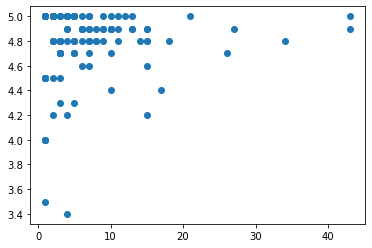

In [67]:
empresas_con_rating = companies.query('reviews != 0')
plt.scatter(empresas_con_rating.reviews, empresas_con_rating.rating)
plt.show()

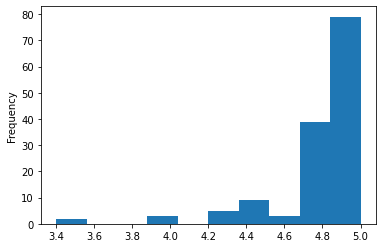

In [69]:
companies.query('rating != 0').rating.astype(float).plot.hist()
plt.show()

## Clustering?

Podriamos armar clusters de empresas para cuando el usuario elija una, le mostremos las caracteristicas de sus competidores mas similares.

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from umap import UMAP

In [93]:
ss = StandardScaler()
x = companies.drop(columns=['company_name', 'location'])
x = ss.fit_transform(x)

In [94]:
umap = UMAP(n_components=4, random_state=42)
x_reduced = umap.fit_transform(x)
df_reduced = pd.DataFrame(x_reduced)

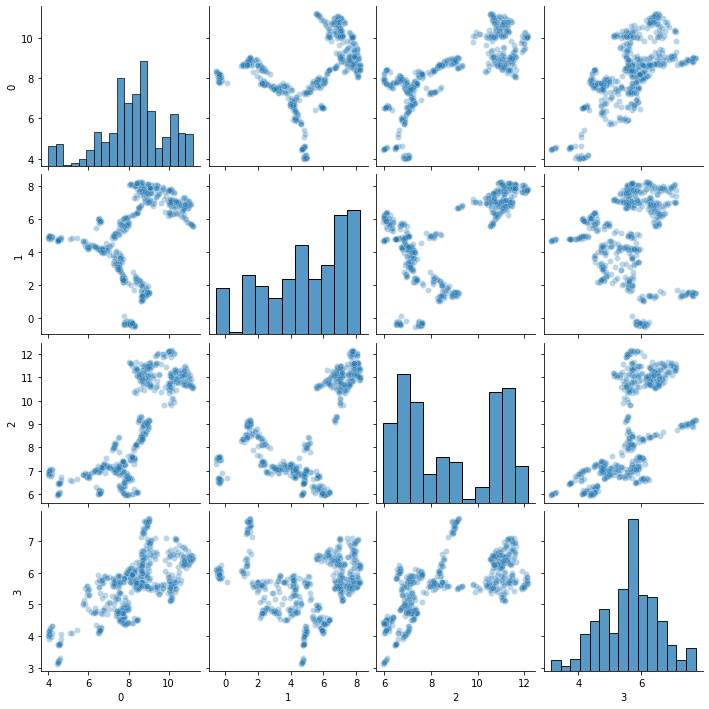

In [95]:
sns.pairplot(df_reduced, kind='scatter', plot_kws={'alpha':0.3})
plt.show()

In [96]:
clustering_model = KMeans(n_clusters=3, random_state=42)
df_reduced['cluster'] = clustering_model.fit_predict(df_reduced)

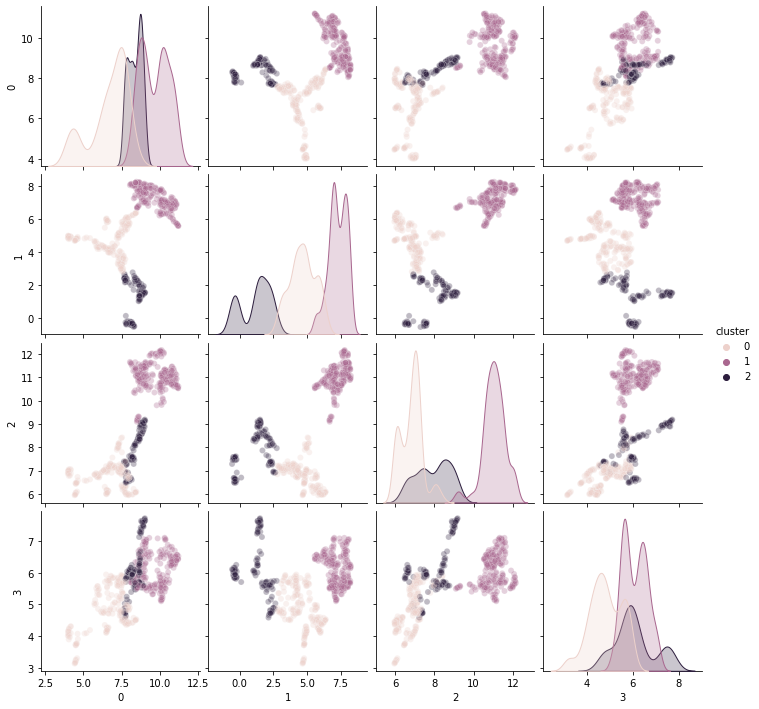

In [97]:
sns.pairplot(df_reduced, hue="cluster", kind='scatter', plot_kws={'alpha':0.3})
plt.show()

In [101]:
model = Pipeline(steps=[
    ("standard_scaler", ss),
    ("umap", umap),
    ("clustering", clustering_model)
])

In [102]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(model, f)

In [103]:
model.predict(companies.drop(columns=['company_name', 'location']))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 0,
       1, 0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1,
       0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1,

-agregar las categorias: web, software dev(ya esta), mobiel
- eliminar duplicados
- elegir una empresa
- sacar client focus
- filtrar aquellas empresas que al menos dos principales (de mayor porcentaje) de las caracteristicas.
- armar métrica de diferencia: cantidad de empleados maximo y restar la elegida, lo mismo con min project size, mismo tarifa. ¿armamos una sola metrica con las tres o las tres por separadas?
- 
- graficar